Saving метеорологические данные Казгидромет.zip to метеорологические данные Казгидромет.zip


<ipython-input-1-aec0505d813a>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subregion_df['month'] = subregion_df['date'].dt.month
<ipython-input-1-aec0505d813a>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subregion_df['year'] = subregion_df['date'].dt.year


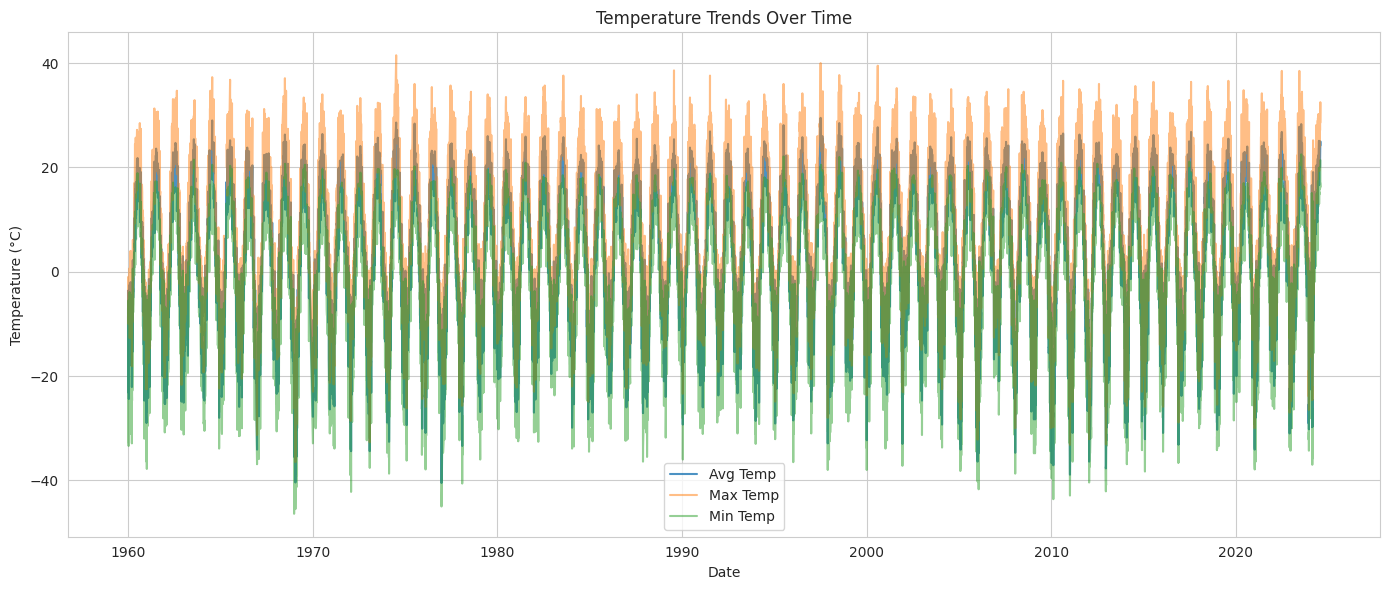

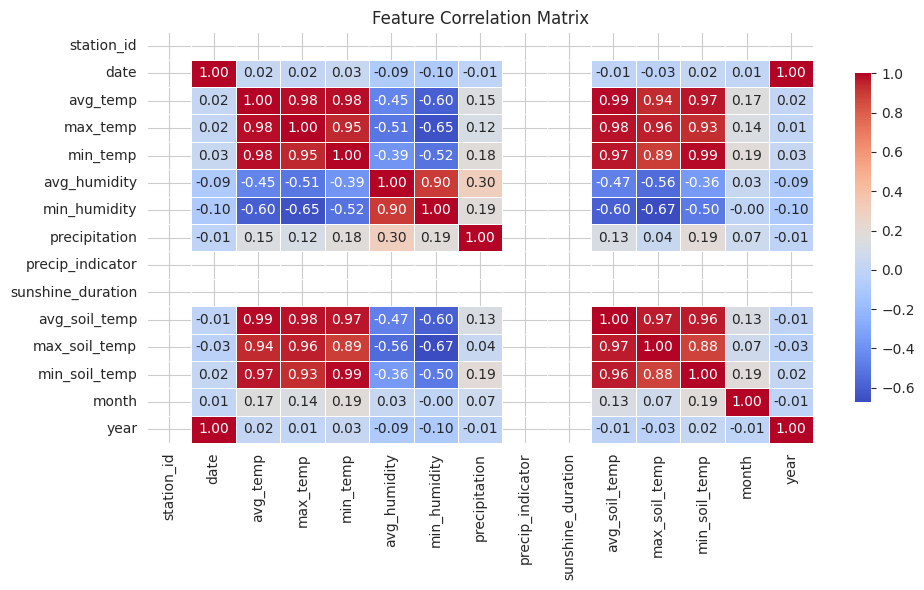

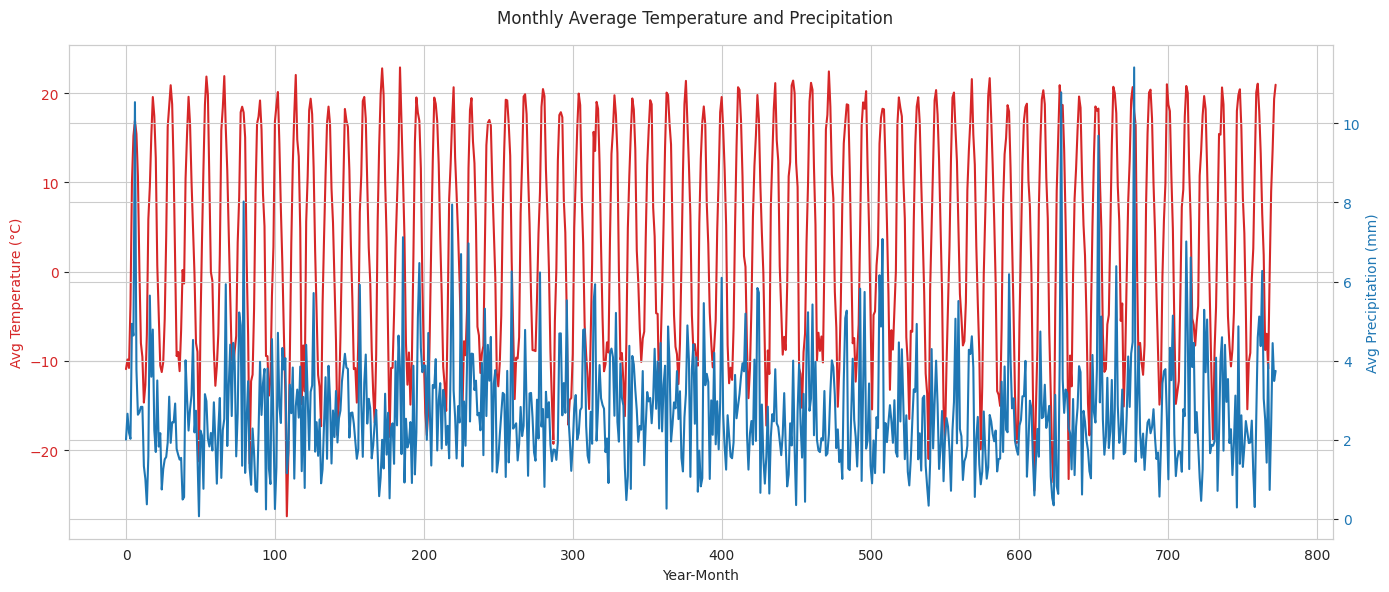

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import files

# Load and process data
def load_and_process_data(extract_path, expected_columns):
    extracted_files = os.listdir(extract_path)
    all_dfs = []
    for file in extracted_files:
        file_path = os.path.join(extract_path, file)
        try:
            df_temp = pd.read_excel(file_path)
            if len(df_temp.columns) == len(expected_columns):
                df_temp.columns = expected_columns
            else:
                continue
            df_temp["date"] = pd.to_datetime(df_temp["date"], errors='coerce')
            numeric_cols = ["avg_temp", "max_temp", "min_temp", "avg_humidity", "min_humidity",
                            "precipitation", "sunshine_duration", "avg_soil_temp", "max_soil_temp", "min_soil_temp"]
            df_temp[numeric_cols] = df_temp[numeric_cols].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')
            df_temp = df_temp.dropna(subset=["date", "avg_temp", "precipitation"])
            all_dfs.append(df_temp)
        except:
            continue
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else None

# Upload and extract data
uploaded = files.upload()
zip_filename = next(iter(uploaded.keys()))
extract_path = "./extracted_data"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

expected_columns = [
    "station_id", "date", "avg_temp", "max_temp", "min_temp",
    "avg_humidity", "min_humidity", "precipitation", "precip_indicator",
    "sunshine_duration", "avg_soil_temp", "max_soil_temp", "min_soil_temp"
]
df = load_and_process_data(extract_path, expected_columns)
if df is None:
    exit()

# Subregion data and additional columns
subregion_df = df[df["station_id"] == df["station_id"].mode()[0]]
subregion_df['month'] = subregion_df['date'].dt.month
subregion_df['year'] = subregion_df['date'].dt.year

sns.set_style("whitegrid")

# 1. Time Series Plot for Temperature Trends
plt.figure(figsize=(14, 6))
plt.plot(subregion_df['date'], subregion_df['avg_temp'], label='Avg Temp', alpha=0.8)
plt.plot(subregion_df['date'], subregion_df['max_temp'], label='Max Temp', alpha=0.5)
plt.plot(subregion_df['date'], subregion_df['min_temp'], label='Min Temp', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Enhanced Correlation Matrix
plt.figure(figsize=(10, 6))
corr_matrix = subregion_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 3. Combined Line Chart for Monthly Avg Temperature and Precipitation
monthly_summary = subregion_df.groupby(['year', 'month']).agg({
    'avg_temp': 'mean',
    'precipitation': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:red'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Avg Temperature (°C)', color=color)
ax1.plot(monthly_summary.index, monthly_summary['avg_temp'], color=color, label='Avg Temp')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Precipitation (mm)', color=color)
ax2.plot(monthly_summary.index, monthly_summary['precipitation'], color=color, label='Avg Precipitation')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Monthly Average Temperature and Precipitation")
fig.tight_layout()
plt.show()
